# instrument1

## Instructions

Execute the code blocks below in order. The headers of each cell explains what the corresponding code does. A full explanation is available in jupyter.md.

## Reference

* https://www.tensorflow.org/lite/microcontrollers/get_started
* https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb
* https://github.com/arduino/ArduinoTensorFlowLiteTutorials/tree/master/GestureToEmoji

## Install Python packages

In [1]:
# version from colab
# !apt-get -qq install xxd

# TODO: how to install xxd with python or how to replace it

#######

# version from colab: 
# !pip install tensorflow pandas numpy matplotlib

# following recommendations from
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install tensorflow pandas numpy matplotlib

You should consider upgrading via the '/home/ptone/Documents/MIT/urop/tiny-trainable-instruments/instruments/env/bin/python -m pip install --upgrade pip' command.


## Upload data

* This Jupyter notebook lives right next to a folder called data
* The data lives in the files gesture0.csv, gesture1.csv, and gesture2.csv
* For generating your own data and replacing these files, use the sketch inst1_collecting_data

## Graph data

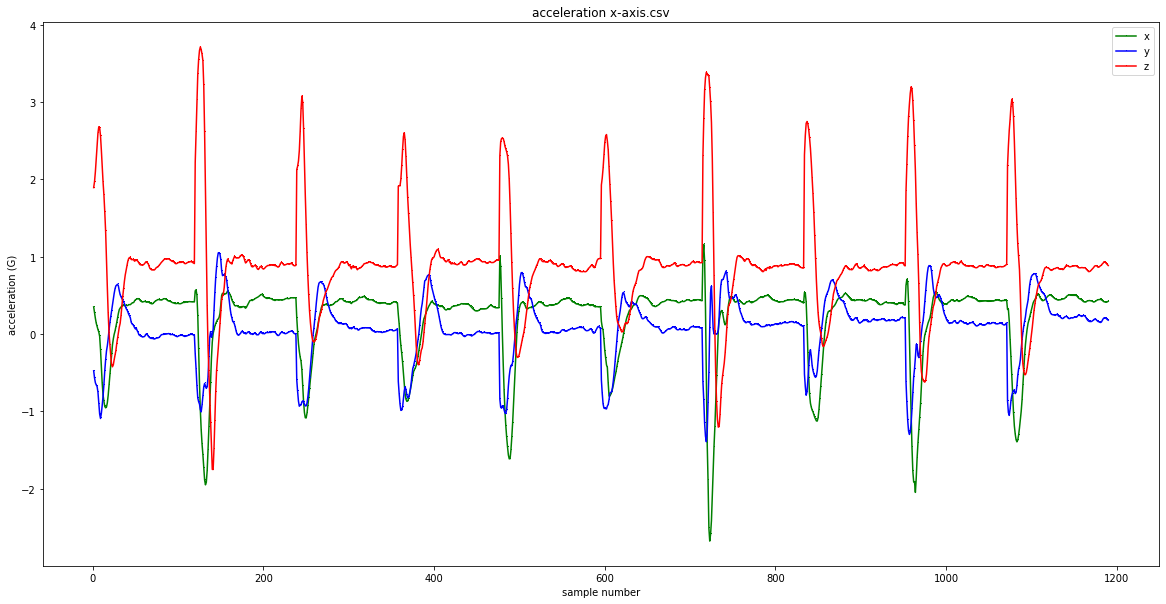

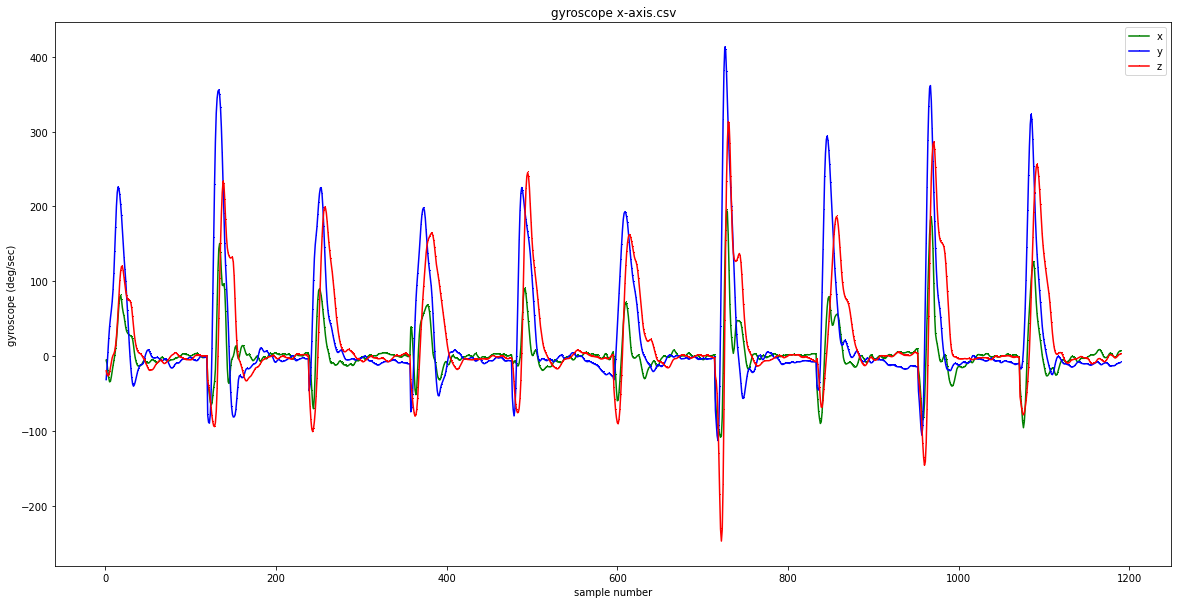

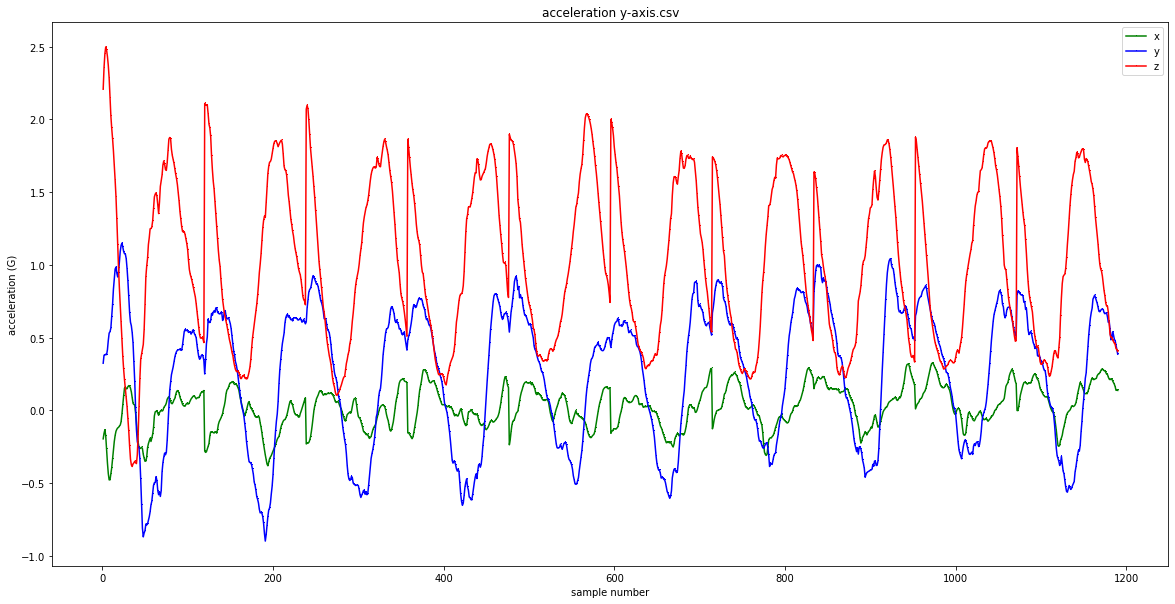

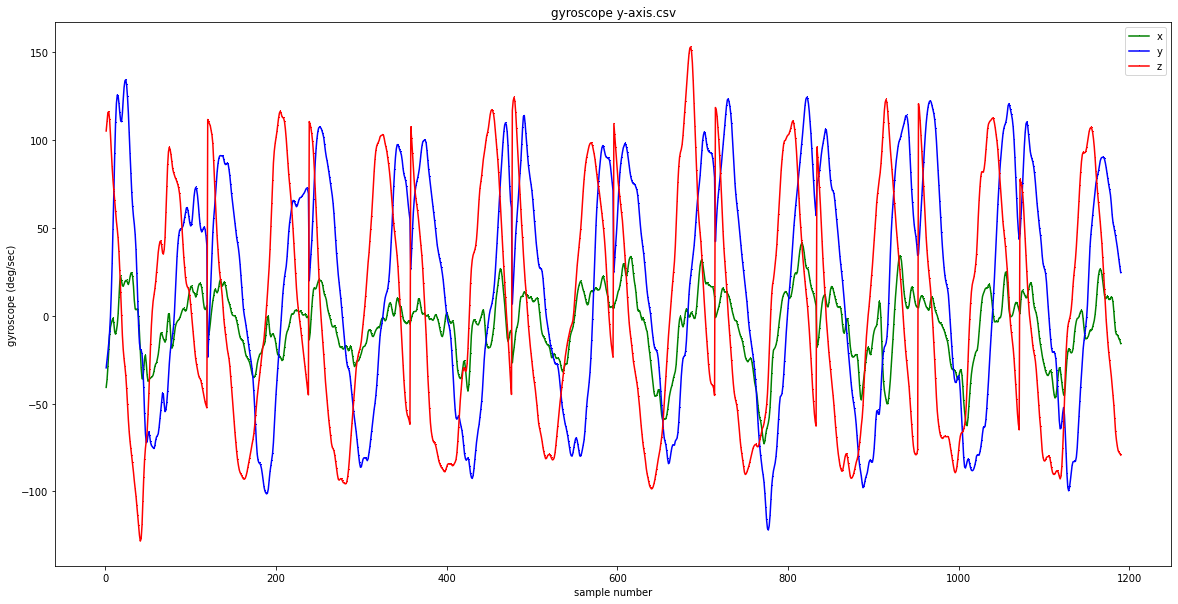

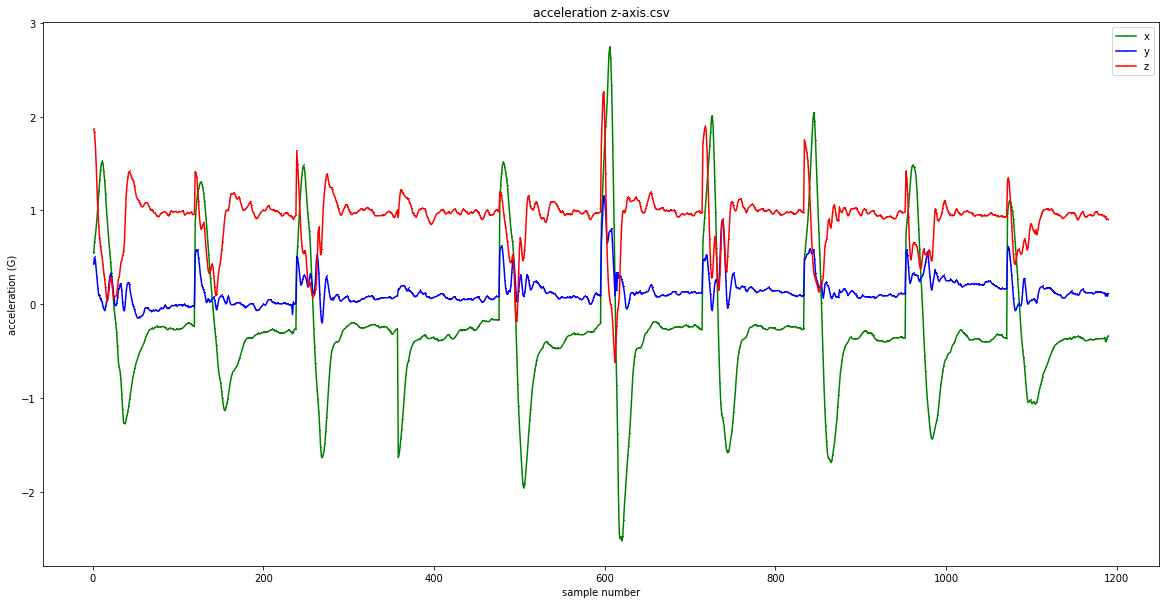

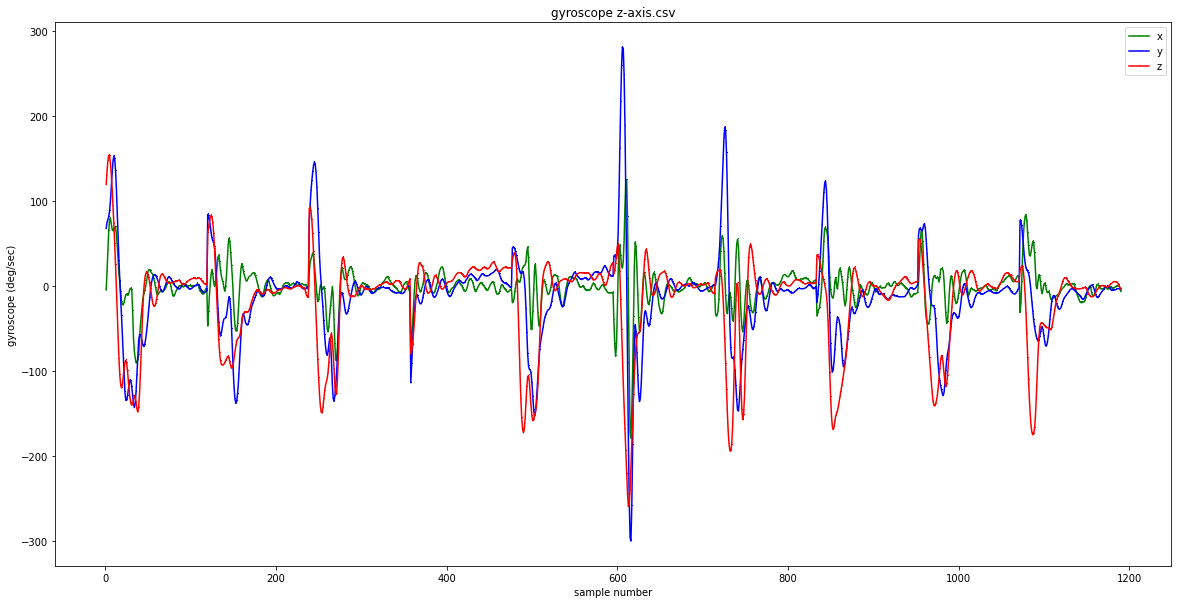

In [2]:
# import Python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# list of filenames
filenames = ["x-axis.csv", "y-axis.csv", "z-axis.csv"]

# create list of readings with pandas
df = list()
for i in range(len(filenames)):
    df.append(pd.read_csv("./data/" + filenames[i]))

# create list of indices
indices = list()
for i in range(len(df)):
    indices.append(range(1, len(df[i]['aX']) + 1))
    
# TODO: what does this line do?
plt.rcParams["figure.figsize"] = (20,10)

# plot acceleration and gyroscope data for each file
for i in range(len(df)):
    plt.plot(indices[i], df[i]['aX'], 'g.', label='x', linestyle='solid', marker=',')
    plt.plot(indices[i], df[i]['aY'], 'b.', label='y', linestyle='solid', marker=',')
    plt.plot(indices[i], df[i]['aZ'], 'r.', label='z', linestyle='solid', marker=',')
    plt.title("acceleration " + filenames[i])
    plt.xlabel("sample number")
    plt.ylabel("acceleration (G)")
    plt.legend()
    plt.show()

    plt.plot(indices[i], df[i]['gX'], 'g.', label='x', linestyle='solid', marker=',')
    plt.plot(indices[i], df[i]['gY'], 'b.', label='y', linestyle='solid', marker=',')
    plt.plot(indices[i], df[i]['gZ'], 'r.', label='z', linestyle='solid', marker=',')
    plt.title("gyroscope " + filenames[i])
    plt.xlabel("sample number")
    plt.ylabel("gyroscope (deg/sec)")
    plt.legend()
    plt.show()

## Parse data

In [3]:
# import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# print TensorFlow version
print(f"TensorFlow version = {tf.__version__}\n")

# set a seed the pseudo-random numbers
# with a seed we get the same pseudo-random numbers each time
seed = 12345
# apply the seed to numpy and tensorflow
np.random.seed(seed)
tf.random.set_seed(seed)

# list of gestures in the data
GESTURES = [
    "x-axis",
    "y-axis",
    "z-axis"
]

# retrieve number of gestures from list
NUM_GESTURES = len(GESTURES)

# number of samples per gesture in each .csv file
SAMPLES_PER_GESTURE = 119

# create a one-hot encoded matrix that is used in the output
# np.eye is an identity matrix, all zeroes but the diagonal
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

# initialize lists for inputs and outputs
inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
    
    # retrieve current gesture
    gesture = GESTURES[gesture_index]
    
    # print status message
    print(f"current index {gesture_index} for gesture '{gesture}'")
    
    # retrieve output
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    
    # read from corresponding csv file
    df = pd.read_csv("./data/" + gesture + ".csv")
    
    # calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
    
    # prints status message
    print(f"\t{num_recordings} recordings in {gesture}")
    
    # go through every recording
    for i in range(num_recordings):
        
        # new list for tensor
        tensor = []
        
        # go through every sample
        for j in range(SAMPLES_PER_GESTURE):
            
            # retrieve index
            index = i * SAMPLES_PER_GESTURE + j
            
            # normalize the input data, to float numbers between 0 to 1
            
            # acceleration current range is -4 to +4
            # so it needs to be offset by 4 and divided by 8
            aOffset = 4
            aDivisor = 8
            
            # gyroscope current range is -2000 to +2000
            # so it needs to be offset by 2000 and divided by 4000
            gOffset = 2000
            gDivisor = 4000
            
            # build tensor with normalized data
            tensor += [
                (df['aX'][index] + aOffset) / aDivisor,
                (df['aY'][index] + aOffset) / aDivisor,
                (df['aZ'][index] + aOffset) / aDivisor,
                (df['gX'][index] + gOffset) / gDivisor,
                (df['gY'][index] + gOffset) / gDivisor,
                (df['gZ'][index] + gOffset) / gDivisor
            ]
            
            # append the tensor to the inputs list
            inputs.append(tensor)
            
            # append the output to the outputs list
            outputs.append(output)

# convert the lists to numpy arrays
inputs = np.array(inputs)
outputs = np.array(outputs)

print("parsing complete")

TensorFlow version = 2.4.1

current index 0 for gesture 'x-axis'
	10 recordings in x-axis
current index 1 for gesture 'y-axis'
	10 recordings in y-axis
current index 2 for gesture 'z-axis'
	10 recordings in z-axis
parsing complete


## Randomize and split the input and output pairs for training 

In [ ]:
# randomly split input and output pairs into sets of data:
# 60% for training, 20% for validation, and 20% for testing

# randomize the order of the inputs,
# so they can be evenly distributed
# for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# swap the consecutive indexes
# (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# split the recordings (group of samples) into three sets:
# training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("data set randomization and splitting complete")

## Build and train the model

In [5]:
# build the model and train it

# model variable for a sequential
model = tf.keras.Sequential()


model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance

model.add(tf.keras.layers.Dense(15, activation='relu'))

model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate), verbose=2)



Epoch 1/600
2142/2142 [==============================] - 6s 2ms/step - loss: 0.2253 - mae: 0.4445 - val_loss: 0.2224 - val_mae: 0.4445
Epoch 2/600
2142/2142 [==============================] - 4s 2ms/step - loss: 0.2224 - mae: 0.4445 - val_loss: 0.2223 - val_mae: 0.4444
Epoch 3/600
2142/2142 [==============================] - 3s 2ms/step - loss: 0.2226 - mae: 0.4447 - val_loss: 0.2225 - val_mae: 0.4445
Epoch 4/600
2142/2142 [==============================] - 4s 2ms/step - loss: 0.2224 - mae: 0.4444 - val_loss: 0.2224 - val_mae: 0.4446
Epoch 5/600
2142/2142 [==============================] - 4s 2ms/step - loss: 0.2223 - mae: 0.4445 - val_loss: 0.2224 - val_mae: 0.4446
Epoch 6/600
2142/2142 [==============================] - 4s 2ms/step - loss: 0.2222 - mae: 0.4443 - val_loss: 0.2221 - val_mae: 0.4443
Epoch 7/600
2142/2142 [==============================] - 4s 2ms/step - loss: 0.2224 - mae: 0.4446 - val_loss: 0.2226 - val_mae: 0.4446
Epoch 8/600
2142/2142 [==============================] 

## Graph the loss

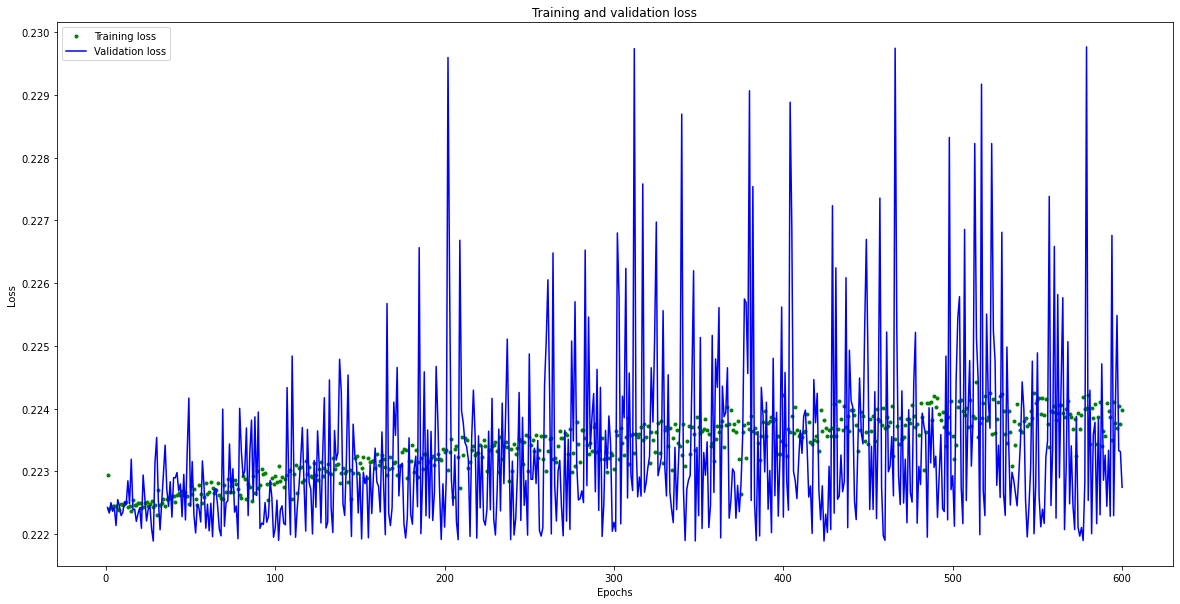

[20.0, 10.0]


In [6]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

## Graph the loss again, skipping a bit of the start

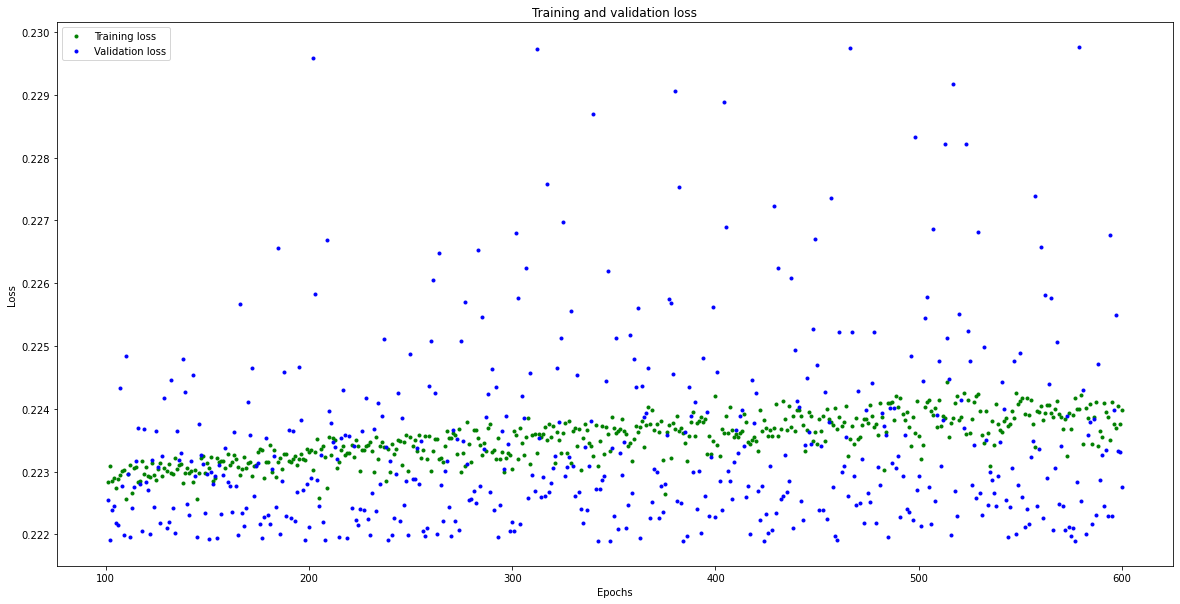

In [7]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Graph the mean absolute error

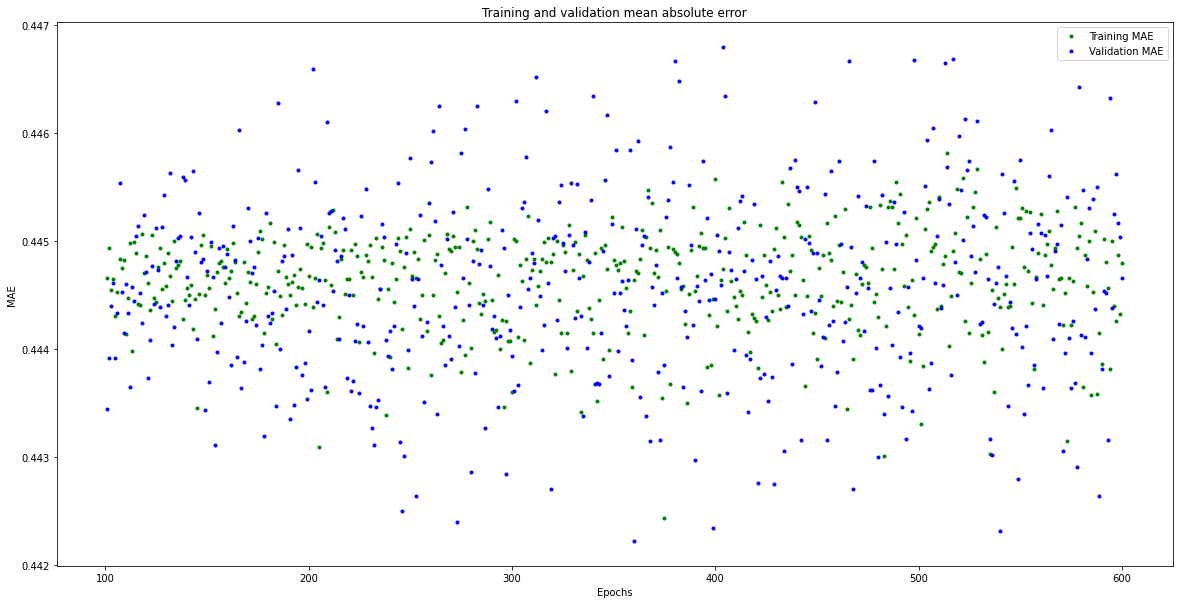

In [8]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()



## Run with test data

In [9]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data

# TODO: this line crashes, i dont know why
# plt.clf()


# plt.title('Training data predicted vs actual values')
# plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
# plt.plot(inputs_test, predictions, 'r.', label='Predicted')
# plt.show()

predictions =
 [[0.329 0.314 0.357]
 [0.329 0.314 0.357]
 [0.329 0.314 0.357]
 ...
 [0.329 0.314 0.357]
 [0.329 0.314 0.357]
 [0.329 0.314 0.357]]
actual =
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


## Convert the trained model to TensorFlow Lite

In [10]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpy495olz9/assets
Model is 147928 bytes


## Encode the model in a header file for Arduino


In [11]:
!echo "const unsigned char model[] = {" > ./data/model.h
!cat gesture_model.tflite | xxd -i      >> ./data/model.h
!echo "};"                              >> ./data/model.h

import os
model_h_size = os.path.getsize("./data/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 912,258 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
